# Chicago Crashes: Phase 3 Project

## Stakeholders & Main Problem

Our stakeholder will be the City of Chicago Department of Transportation (CDOT). We'll focus on identifying the factors that most contribute to an increasing severity of crashes (fatalities, serious injury).

We'll look closely at the columns associated with fatalities and injuries to create targets for this multi-class problem.

## Import datasets

Datasets located at:

* https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if
* https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d

__Load Dependencies__

In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipe

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,\
precision_recall_fscore_support, f1_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_validate, cross_val_predict, cross_val_score


In [2]:
crashes_df = pd.read_csv('data/Traffic_Crashes_-_Crashes.csv', low_memory=False)
people_df = pd.read_csv('data/Traffic_Crashes_-_People.csv', low_memory=False)

In [3]:
crashes_df.head()

,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,JC343143,NaN,07/10/2019 05:56:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,...,0.0,0.0,3.0,0.0,17,4,7,41.919664,-87.773288,POINT (-87.773287883007 41.919663832993)
1,009e9e67203442370272e1a13d6ee51a4155dac65e583d...,JA329216,NaN,06/30/2017 04:00:00 PM,35,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,...,0.0,0.0,3.0,0.0,16,6,6,41.741804,-87.740954,POINT (-87.740953581987 41.741803598989)
2,ee9283eff3a55ac50ee58f3d9528ce1d689b1c4180b4c4...,JD292400,NaN,07/10/2020 10:25:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,...,0.0,0.0,3.0,0.0,10,6,7,41.773456,-87.585022,POINT (-87.585022352022 41.773455972008)
3,f8960f698e870ebdc60b521b2a141a5395556bc3704191...,JD293602,NaN,07/11/2020 01:00:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DARKNESS,PARKED MOTOR VEHICLE,...,0.0,0.0,3.0,0.0,1,7,7,41.802119,-87.622115,POINT (-87.622114914961 41.802118543011)
4,8eaa2678d1a127804ee9b8c35ddf7d63d913c14eda61d6...,JD290451,NaN,07/08/2020 02:00:00 PM,20,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,...,0.0,0.0,1.0,0.0,14,4,7,NaN,NaN,NaN


Explore proportion of missing data

In [4]:
crashes_df.isna().mean()

CRASH_RECORD_ID                  0.000000
RD_NO                            0.008486
CRASH_DATE_EST_I                 0.924181
CRASH_DATE                       0.000000
POSTED_SPEED_LIMIT               0.000000
TRAFFIC_CONTROL_DEVICE           0.000000
DEVICE_CONDITION                 0.000000
WEATHER_CONDITION                0.000000
LIGHTING_CONDITION               0.000000
FIRST_CRASH_TYPE                 0.000000
TRAFFICWAY_TYPE                  0.000000
LANE_CNT                         0.632318
ALIGNMENT                        0.000000
ROADWAY_SURFACE_COND             0.000000
ROAD_DEFECT                      0.000000
REPORT_TYPE                      0.024997
CRASH_TYPE                       0.000000
INTERSECTION_RELATED_I           0.773254
NOT_RIGHT_OF_WAY_I               0.952689
HIT_AND_RUN_I                    0.698892
DAMAGE                           0.000000
DATE_POLICE_NOTIFIED             0.000000
PRIM_CONTRIBUTORY_CAUSE          0.000000
SEC_CONTRIBUTORY_CAUSE           0

Investigate the distribution of the target

In [5]:
people_df.INJURY_CLASSIFICATION.value_counts()

NO INDICATION OF INJURY     1096283
NONINCAPACITATING INJURY      55296
REPORTED, NOT EVIDENT         32092
INCAPACITATING INJURY         10827
FATAL                           656
Name: INJURY_CLASSIFICATION, dtype: int64

## Basic Cleaning

__Drop columns where more than 80% of the data is missing__

In [6]:
def dropna_columns(df, threshold=.8):
    '''
    Drop columns from a Pandas DataFrame in which more than a certain
    percentage (default=80%) of their rows are null/NaN.
    '''
    return df.dropna(thresh=(((1-threshold) * df.shape[0])) + 1, axis=1)

In [7]:
crashes_dropped_df = dropna_columns(crashes_df)
people_dropped_df = dropna_columns(people_df)

In [8]:
crashes_dropped_df.shape

(541142, 41)

In [9]:
people_dropped_df.shape

(1195747, 22)

In [10]:
crashes_dropped_df.columns

Index(['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE', 'POSTED_SPEED_LIMIT',
       'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'LANE_CNT',
       'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE',
       'CRASH_TYPE', 'INTERSECTION_RELATED_I', 'HIT_AND_RUN_I', 'DAMAGE',
       'DATE_POLICE_NOTIFIED', 'PRIM_CONTRIBUTORY_CAUSE',
       'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION',
       'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'NUM_UNITS', 'MOST_SEVERE_INJURY',
       'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING',
       'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT',
       'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE',
       'LOCATION'],
      dtype='object')

In [11]:
people_dropped_df.columns

Index(['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID', 'RD_NO', 'VEHICLE_ID',
       'CRASH_DATE', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 'AGE',
       'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT',
       'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'DRIVER_ACTION',
       'DRIVER_VISION', 'PHYSICAL_CONDITION', 'BAC_RESULT'],
      dtype='object')

__Further drop the columns that are not needed for modeling__

Columns to drop:

Crashes:

* `RD_NO` is a police ID number, withheld for recent crashes; reduntant w/ `CRASH_RECORD_ID`
* `REPORT_TYPE` not relevant to conditions in a crash
* `CRASH_DATE` is redundant with data in people
* `DATE_POLICE_NOTIFIED` - an after the accident feature not used for prediction
* `STREET_NO`, `STREET_DIRECTION`, `STREET_NAME` are all location related; just use lat/long
* All the `INJURIES_` columns--colinearity issues w/individual injury data

Vehicles:

* `RD_NO` is a police ID number, withheld for recent crashes; reduntant w/ `CRASH_RECORD_ID`
* `CRASH_DATE` (redundant w/crashes_df)
* `UNIT_NO` is redundant (count of num vehicles in crash)
* `AREA_01_I` is unclear

People:

* `RD_NO` is a police ID number, withheld for recent crashes; reduntant w/ `CRASH_RECORD_ID`
* `CITY` and `ZIPCODE`; just use `STATE` to determine driver residence

In [12]:
crashes_cols_to_drop = ['CRASH_DATE', 'RD_NO', 'REPORT_TYPE', 'DATE_POLICE_NOTIFIED', 'STREET_NO', 'STREET_DIRECTION', 
                        'STREET_NAME', 'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING',
                        'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
                        'INJURIES_UNKNOWN', 'MOST_SEVERE_INJURY']

people_cols_to_drop = ['RD_NO', 'CITY', 'ZIPCODE']

In [13]:
crashes_dropped_df = crashes_dropped_df.drop(crashes_cols_to_drop, axis=1)

people_dropped_df = people_dropped_df.drop(people_cols_to_drop, axis=1)

In [14]:
crashes_dropped_df.shape

(541142, 26)

In [15]:
people_dropped_df.shape

(1195747, 19)

## Merging into one dataframe

Since we are focusing on predicting individual outcomes in crashes, we will merge on people_dropped_df in a left join with crashes_dropped_df and vehicles_dropped_df. This will allow us to create a `TARGET` column based on the injury that each individual person incurred during the crash.

In [16]:
people_crashes_df = people_dropped_df.merge(crashes_dropped_df, on='CRASH_RECORD_ID', how='left')

In [17]:
people_crashes_df.shape

(1195747, 44)

In [18]:
people_crashes_df.columns

Index(['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID', 'VEHICLE_ID',
       'CRASH_DATE', 'SEAT_NO', 'STATE', 'SEX', 'AGE', 'DRIVERS_LICENSE_STATE',
       'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED',
       'EJECTION', 'INJURY_CLASSIFICATION', 'DRIVER_ACTION', 'DRIVER_VISION',
       'PHYSICAL_CONDITION', 'BAC_RESULT', 'POSTED_SPEED_LIMIT',
       'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'LANE_CNT',
       'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'CRASH_TYPE',
       'INTERSECTION_RELATED_I', 'HIT_AND_RUN_I', 'DAMAGE',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE',
       'BEAT_OF_OCCURRENCE', 'NUM_UNITS', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK',
       'CRASH_MONTH', 'LATITUDE', 'LONGITUDE', 'LOCATION'],
      dtype='object')

__Examine target variable__

In [19]:
people_crashes_df.INJURY_CLASSIFICATION.value_counts()

NO INDICATION OF INJURY     1096283
NONINCAPACITATING INJURY      55296
REPORTED, NOT EVIDENT         32092
INCAPACITATING INJURY         10827
FATAL                           656
Name: INJURY_CLASSIFICATION, dtype: int64

In [20]:
people_crashes_df['TARGET'] = people_crashes_df['INJURY_CLASSIFICATION'].map({np.NaN: 0, 
                                                                              'NO INDICATION OF INJURY': 0, 
                                                                              'NONINCAPACITATING INJURY': 1,
                                                                              'REPORTED, NOT EVIDENT': 1,
                                                                              'INCAPACITATING INJURY': 2,
                                                                              'FATAL': 3})
people_crashes_df['TARGET'].value_counts()

0    1096876
1      87388
2      10827
3        656
Name: TARGET, dtype: int64

__Make a `CRASH_YEAR` column__

In [21]:
people_crashes_df['CRASH_YEAR'] = pd.to_datetime(people_crashes_df['CRASH_DATE']).dt.year

In [22]:
people_crashes_df['CRASH_YEAR'].value_counts()

2018    265694
2019    263972
2020    202084
2017    185328
2021    161704
2016     96020
2015     20931
2014        11
2013         3
Name: CRASH_YEAR, dtype: int64

In [23]:
people_crashes_df.columns

Index(['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID', 'VEHICLE_ID',
       'CRASH_DATE', 'SEAT_NO', 'STATE', 'SEX', 'AGE', 'DRIVERS_LICENSE_STATE',
       'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED',
       'EJECTION', 'INJURY_CLASSIFICATION', 'DRIVER_ACTION', 'DRIVER_VISION',
       'PHYSICAL_CONDITION', 'BAC_RESULT', 'POSTED_SPEED_LIMIT',
       'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'LANE_CNT',
       'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'CRASH_TYPE',
       'INTERSECTION_RELATED_I', 'HIT_AND_RUN_I', 'DAMAGE',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE',
       'BEAT_OF_OCCURRENCE', 'NUM_UNITS', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK',
       'CRASH_MONTH', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'TARGET',
       'CRASH_YEAR'],
      dtype='object')

## Split the data for cleaning and training

In [24]:
people_crashes_df.shape

(1195747, 46)

Drop null values from the numerical columns that are missing data

In [57]:
# Drop nulls from BEAT_OF_OCCURRENCE
people_crashes_df.dropna(subset = ['BEAT_OF_OCCURRENCE'], inplace=True)

# Drop ages < 0 and ages = 0 for AGE
people_crashes_df.loc[people_crashes_df.AGE < 0, 'AGE'] = np.nan
people_crashes_df.loc[(people_crashes_df.AGE == 0) & (people_crashes_df.PERSON_TYPE == 'DRIVER'), 'AGE'] = np.nan
people_crashes_df.dropna(subset = ['AGE'], inplace=True)

# Drop POSTED_SPEED_LIMIT = 0 or not divisible by 5
people_crashes_df.loc[people_crashes_df.POSTED_SPEED_LIMIT == 0, 'POSTED_SPEED_LIMIT'] = np.nan
people_crashes_df.loc[(people_crashes_df.POSTED_SPEED_LIMIT % 5) != 0, 'POSTED_SPEED_LIMIT'] = np.nan
people_crashes_df.dropna(subset = ['POSTED_SPEED_LIMIT'], inplace=True)

In [26]:
people_crashes_df.shape

(836073, 46)

In [58]:
X = people_crashes_df.drop(['PERSON_ID', 'CRASH_RECORD_ID', 'VEHICLE_ID', 'CRASH_DATE', 'LANE_CNT', 
                            'DRIVERS_LICENSE_STATE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'CRASH_TYPE',
                            'INJURY_CLASSIFICATION', 'TARGET'], axis=1)
y = people_crashes_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

## Clean the data

We'll make use of Piplines to streamline the process and make it easier to apply techniques/transformations/functions to both `X_train` and `X_test`.

In [59]:
X_train.head()

,PERSON_TYPE,SEAT_NO,STATE,SEX,AGE,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,DRIVER_ACTION,...,HIT_AND_RUN_I,DAMAGE,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,BEAT_OF_OCCURRENCE,NUM_UNITS,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,CRASH_YEAR
630156,DRIVER,NaN,IL,M,31.0,D,SAFETY BELT USED,NOT APPLICABLE,NONE,NONE,...,NaN,"OVER $1,500",UNABLE TO DETERMINE,UNABLE TO DETERMINE,1834.0,2.0,9,5,2,2019
526318,DRIVER,NaN,IL,F,40.0,D,SAFETY BELT USED,DID NOT DEPLOY,NONE,NONE,...,NaN,"OVER $1,500",FOLLOWING TOO CLOSELY,EXCEEDING AUTHORIZED SPEED LIMIT,1654.0,2.0,8,4,8,2018
396186,DRIVER,NaN,IL,M,39.0,D,USAGE UNKNOWN,DID NOT DEPLOY,NONE,FOLLOWED TOO CLOSELY,...,N,$500 OR LESS,FOLLOWING TOO CLOSELY,UNABLE TO DETERMINE,731.0,2.0,22,1,2,2018
600600,DRIVER,NaN,IL,F,51.0,D,USAGE UNKNOWN,DID NOT DEPLOY,NONE,OTHER,...,NaN,"OVER $1,500",DISREGARDING TRAFFIC SIGNALS,TURNING RIGHT ON RED,323.0,2.0,17,1,12,2018
242723,DRIVER,NaN,IL,F,41.0,D,SAFETY BELT USED,DID NOT DEPLOY,NONE,FAILED TO YIELD,...,NaN,"$501 - $1,500",UNABLE TO DETERMINE,UNABLE TO DETERMINE,2512.0,2.0,12,6,4,2017


Define functions to clean the data to be put in a cleaning pipeline

In [60]:
def seat_no_transformer(df):
    '''
    Set all SEAT_NO = 1 if PERSON_TYPE = 'DRIVER'
    and fill the rest with 0.
    '''
    df.loc[(df.PERSON_TYPE == 'DRIVER'), 'SEAT_NO'] = 1
    df['SEAT_NO'].fillna(value=0, inplace=True)
    return df

In [61]:
def beat_transformer(df):
    '''
    Extract and encode as a string the district
    from BEAT_OF_OCCURRENCE.
    '''
    df['BEAT_OF_OCCURRENCE'] = df['BEAT_OF_OCCURRENCE'].apply(str)
    df['BEAT_OF_OCCURRENCE'] = df['BEAT_OF_OCCURRENCE'].apply(lambda x: x[:-4])
    # df.drop('BEAT_OF_OCCURRENCE', axis=1, inplace=True)
    return df

In [62]:
def license_class_transformer(df):
    '''
    Bin all license classes into A, B, C, D, and OTHER
    '''
    dl_classes = ['A', 'B', 'C', 'D', np.nan]
    df.loc[df['DRIVERS_LICENSE_CLASS'].isin(dl_classes) == False, 'DRIVERS_LICENSE_CLASS'] = 'OTHER'
    return df

In [63]:
def to_float_transformer(df):
    '''
    Ensure all columns are float, not int.
    '''
    for col in [df.select_dtypes('int64').columns]:
        df[col] = df[col].astype('float64')
    return df

In [72]:
def fill_categories(df):
    '''
    Fill null values with given value for 
    unknown values in that column.
    Drop all remaining nulls.
    '''
    df.fillna({'STATE':'XX', 
               'DRIVERS_LICENSE_CLASS': 'D', # Most common; D = 'normal' drivers license for cars
               'EJECTION': 'UNKNOWN',
               'DRIVER_ACTION': 'UNKNOWN',
               'DRIVER_VISION': 'UNKNOWN',
               'PHYSICAL_CONDITION': 'UNKNOWN',
               'SAFETY_EQUIPMENT': 'USAGE_UNKNOWN',
               'AIRBAG_DEPLOYED': 'DEPLOYMENT_UNKNOWN',
               'SEX': 'UNKNOWN',
               'INTERSECTION_RELATED_I': 'N',
               'HIT_AND_RUN_I': 'N',
               'BAC_RESULT': 'TEST NOT OFFERED'
              }, inplace=True)
    return df

In [73]:
def fill_categories_smaller(df):
    '''
    Fill null values with given value for 
    unknown values in that column.
    Drop all remaining nulls.
    '''
    df.fillna({'EJECTION': 'UNKNOWN',
               'DRIVER_ACTION': 'UNKNOWN',
               'SAFETY_EQUIPMENT': 'USAGE_UNKNOWN',
               'AIRBAG_DEPLOYED': 'DEPLOYMENT_UNKNOWN',
               'SEX': 'UNKNOWN',
              }, inplace=True)
    df.dropna()
    return df

__Establish cleaned predictors__

In [66]:
ohe_cols = list(X_train.select_dtypes('object').columns)
ohe_cols.append('BEAT_OF_OCCURRENCE')

# OneHotEncode the columns as part of cleaning
# to avoid needing to separate numerical and categorical
# columns later
ohe_col_trans = ColumnTransformer(transformers=
                                  [('ohe', OneHotEncoder(drop='first', sparse=False), ohe_cols)],
                                 remainder='passthrough')

# Apply all our cleaning functions, then finish with ohe
cleaning_pipeline = Pipeline(steps=[
    ('seat_no', FunctionTransformer(seat_no_transformer)),
    ('beat', FunctionTransformer(beat_transformer)),
    ('license', FunctionTransformer(license_class_transformer)),
    ('fill_cat', FunctionTransformer(fill_categories)),
    ('float', FunctionTransformer(to_float_transformer)),
    ('col_trains', ohe_col_trans)
])

In [67]:
X_train_clean = cleaning_pipeline.fit_transform(X_train)

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-61-41f05342683b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [68]:
ohe_feature_names = cleaning_pipeline.steps[-1][1].get_feature_names()

__Establish cleaned predictors AFTER feature analysis__

In [69]:
X_train_smaller = X_train[['PERSON_TYPE', 'SEX', 'SAFETY_EQUIPMENT', 'AGE', 'AIRBAG_DEPLOYED', 
                           'EJECTION', 'DRIVER_ACTION', 'SEAT_NO', 'LIGHTING_CONDITION', 'WEATHER_CONDITION', 
                           'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE', 
                           'BEAT_OF_OCCURRENCE', 'NUM_UNITS']]

In [70]:
ohe_cols = list(X_train_smaller.select_dtypes('object').columns)
ohe_cols.append('BEAT_OF_OCCURRENCE')

# OneHotEncode the columns as part of cleaning
# to avoid needing to separate numerical and categorical
# columns later
ohe_col_trans = ColumnTransformer(transformers=
                                  [('ohe', OneHotEncoder(drop='first', sparse=False), ohe_cols)],
                                 remainder='passthrough')

# Apply all our cleaning functions, then finish with ohe
cleaning_pipeline_smaller = Pipeline(steps=[
    ('seat_no', FunctionTransformer(seat_no_transformer)),
    ('beat', FunctionTransformer(beat_transformer)),
    ('fill_cat_small', FunctionTransformer(fill_categories_smaller)),
    ('float', FunctionTransformer(to_float_transformer)),
    ('col_trains', ohe_col_trans)
])

In [74]:
X_train_smaller_clean = cleaning_pipeline_smaller.fit_transform(X_train_smaller)

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-61-41f05342683b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [41]:
ohe_feature_names_smaller = cleaning_pipeline_smaller.steps[-1][1].get_feature_names()

## Model Iterations

For each model we will build a pipeline using StandardScaler and the model of choice. Some models will use SMOTE to over sample the minority class to help account for the class imbalance. Then we will evaluate the model by running the pipeline through cross_validate.

In [42]:
from sklearn.model_selection import cross_validate

def print_cv_scores(pipe, X, y):
    scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']
    # we pass in pipe to cross validate along with a feature list.
    results = cross_validate(pipe, X, 
                                   y, 
                                   return_train_score=True, scoring=scoring)
    
    print(results['train_accuracy'])
    print('Training Accuracy', results['train_accuracy'].mean())
    print('##############')
    print(results['test_accuracy'])
    print('Cross_Val Accuracy', results['test_accuracy'].mean())
    print('##############')
    print('Training Macro Precision:', results['train_precision_macro'].mean())
    print('Cross_Val Macro Precision:', results['test_precision_macro'].mean())
    print('##############')
    print('Training Macro Recall:', results['train_recall_macro'].mean())
    print('Cross_Val Macro Recall:', results['test_recall_macro'].mean())
    print('##############')
    print('Training Macro F1:', results['train_f1_macro'].mean())
    print('Cross_Val Macro F1:', results['test_f1_macro'].mean())

### Dummy Classifier

In [43]:
dummy_pipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('dc', DummyClassifier(strategy='most_frequent'))
])

In [44]:
dummy_pipe.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('dc', DummyClassifier(strategy='most_frequent'))])

In [45]:
print_cv_scores(dummy_pipe, X_train_clean, y_train)

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

[0.89149056 0.89149056 0.89149056 0.89149256 0.89149078]
Training Accuracy 0.8914910039646609
##############
[0.89149277 0.89149277 0.89149277 0.8914848  0.89149191]
Cross_Val Accuracy 0.8914910039660102
##############
Training Macro Precision: 0.2228727509911652
Cross_Val Macro Precision: 0.22287275099150256
##############
Training Macro Recall: 0.25
Cross_Val Macro Recall: 0.25
##############
Training Macro F1: 0.23565827225608804
Cross_Val Macro F1: 0.2356582722556019


/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


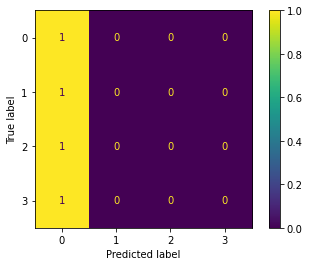

In [46]:
plot_confusion_matrix(dummy_pipe, X_train_clean, y_train, normalize='true')

The results of the dummy classifier show high accuracy, but low macro recall, which is expected with the high level of class imbalance and the nature of the dummy classifier to predict all records as the majority class.

### Decision Tree

For the decision tree model, we use the data after SMOTE and set the `class_weight` to balanced.

In [95]:
dt_pipe = imbpipe(steps=[
    ('ss', StandardScaler()),
    ('sm', SMOTE(random_state=42)),
    ('dtc', DecisionTreeClassifier(random_state=42, 
                                   max_depth= 6, 
                                   class_weight = 'balanced'))])

In [96]:
dt_pipe.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('sm', SMOTE(random_state=42)),
                ('dtc',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                                        random_state=42))])

In [97]:
print_cv_scores(dt_pipe, X_train_clean, y_train)

[0.84869319 0.84992714 0.84896032 0.85346551 0.84649871]
Training Accuracy 0.8495089749089642
##############
[0.84857788 0.85181523 0.84796389 0.85158399 0.84565824]
Cross_Val Accuracy 0.8491198469962619
##############
Training Macro Precision: 0.35841336635148524
Cross_Val Macro Precision: 0.35634335575929244
##############
Training Macro Recall: 0.5053382294178026
Cross_Val Macro Recall: 0.48953092056350567
##############
Training Macro F1: 0.3516994648656303
Cross_Val Macro F1: 0.3492952151617545


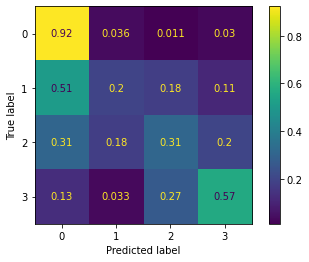

In [98]:
plot_confusion_matrix(dt_pipe, X_train_clean, y_train, normalize='true');

### Random Forest

__Random Forest - Iteration #1__

For the first random forest model we will incorporate SMOTE, balance the class weight, and run parameters that will restrict the decision trees and reduce runtime.

In [130]:
rf_pipe0 = imbpipe(steps=[
    ('ss', StandardScaler()),
    ('sm', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(max_depth = 4,
                                  n_estimators = 50,
                                  class_weight = 'balanced',
                                  random_state = 42))
])

In [131]:
rf_pipe0.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('sm', SMOTE(random_state=42)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=4,
                                        n_estimators=50, random_state=42))])

In [132]:
print_cv_scores(rf_pipe0, X_train_clean, y_train)

[0.81501386 0.82204277 0.82525023 0.82062144 0.81434643]
Training Accuracy 0.819454945311136
##############
[0.81446604 0.82196139 0.82527848 0.82096467 0.81460011]
Cross_Val Accuracy 0.8194541381539284
##############
Training Macro Precision: 0.3218579426598521
Cross_Val Macro Precision: 0.32123953275148687
##############
Training Macro Recall: 0.5061291053783532
Cross_Val Macro Recall: 0.495975868795269
##############
Training Macro F1: 0.31804050437941933
Cross_Val Macro F1: 0.3170151900134942


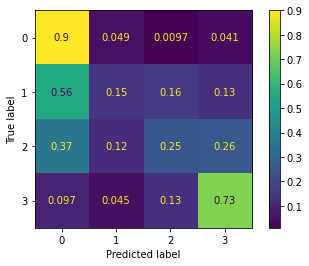

In [133]:
plot_confusion_matrix(rf_pipe0, X_train_clean, y_train, normalize='true');

__Random Forest - Iteration #2__

For the second iteration of the random forest model we reduced the number of features, ran SMOTE, and limited the `max_depth` to 4 to avoid overfitting and increase runtime.

In [99]:
rf_pipe = imbpipe(steps=[
    ('ss', StandardScaler()),
    ('sm', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(max_depth = 4,
                                  n_estimators = 50,
                                  random_state = 42))
])

In [100]:
rf_pipe.fit(X_train_smaller_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('sm', SMOTE(random_state=42)),
                ('rf',
                 RandomForestClassifier(max_depth=4, n_estimators=50,
                                        random_state=42))])

In [102]:
print_cv_scores(rf_pipe, X_train_smaller_clean, y_train)

[0.80726333 0.80896773 0.81681594 0.81178248 0.81373843]
Training Accuracy 0.8117135836686934
##############
[0.80839799 0.80850962 0.81616445 0.81152371 0.8153656 ]
Cross_Val Accuracy 0.8119922739880885
##############
Training Macro Precision: 0.32563499374524063
Cross_Val Macro Precision: 0.3257671083500581
##############
Training Macro Recall: 0.48437949291477533
Cross_Val Macro Recall: 0.47772558905346607
##############
Training Macro F1: 0.3275426071464266
Cross_Val Macro F1: 0.3275850237857922


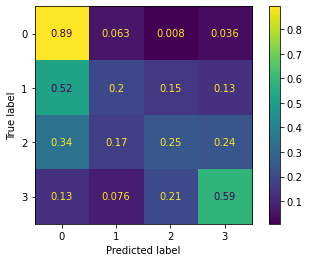

In [103]:
plot_confusion_matrix(rf_pipe, X_train_smaller_clean, y_train, normalize='true');

After this second iteration of the random forest model, we can see that by reducing the features we did not increase performance.

__Random Forest - Iteration #3__

In the third iteration, we want to see if the default hyperparameters increase performance on the random forest while continuing to use SMOTE for the class imbalance and the reduced features.

In [117]:
rf_pipe2 = imbpipe(steps=[
    ('ss', StandardScaler()),
    ('sm', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(max_depth = 6,
                                  n_estimators = 100,
                                  random_state = 42))
])

In [118]:
rf_pipe2.fit(X_train_smaller_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('sm', SMOTE(random_state=42)),
                ('rf', RandomForestClassifier(max_depth=6, random_state=42))])

In [119]:
print_cv_scores(rf_pipe2, X_train_smaller_clean, y_train)

[0.81800205 0.8129945  0.81173464 0.81381779 0.80968575]
Training Accuracy 0.8132469466589773
##############
[0.81839711 0.81280749 0.81057483 0.81301481 0.80993541]
Cross_Val Accuracy 0.8129459296798714
##############
Training Macro Precision: 0.3329830876437244
Cross_Val Macro Precision: 0.33111652073686565
##############
Training Macro Recall: 0.5170135249926229
Cross_Val Macro Recall: 0.49108120536376376
##############
Training Macro F1: 0.34559925031812677
Cross_Val Macro F1: 0.3427623518918345


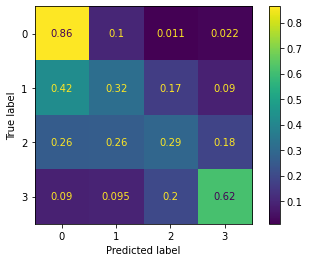

In [120]:
plot_confusion_matrix(rf_pipe2, X_train_smaller_clean, y_train, normalize='true')

### XGBoost

__XGBoost - Iteration #1__

In this first iteration, we ran the model using similar hyperparameters to the second random forest to see the impact of the gradient boosting on a lower performing model.

In [104]:
xgb_pipe = imbpipe(steps=[
    ('ss', StandardScaler()),
    ('sm', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(random_state=42,
                          max_depth = 5,
                          tree_method='hist',
                          n_estimators = 50,
                          n_jobs = -1))
])

In [105]:
xgb_pipe.fit(X_train_smaller_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('sm', SMOTE(random_state=42)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=5, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=-1, num_parallel_tree=1,
                               objective='multi:softprob', random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1, tree_method='hist',
                               validate_parameters=1, verbosity=None

In [106]:
print_cv_scores(xgb_pipe, X_train_smaller_clean, y_train)

[0.87740485 0.87670913 0.87863082 0.88040898 0.87721173]
Training Accuracy 0.8780731009057327
##############
[0.87647814 0.87566481 0.87662964 0.8782244  0.87528905]
Cross_Val Accuracy 0.8764572091587691
##############
Training Macro Precision: 0.419135879565309
Cross_Val Macro Precision: 0.3921561185913144
##############
Training Macro Recall: 0.4991096354297639
Cross_Val Macro Recall: 0.4183153875581319
##############
Training Macro F1: 0.4277737282590765
Cross_Val Macro F1: 0.39239016208862365


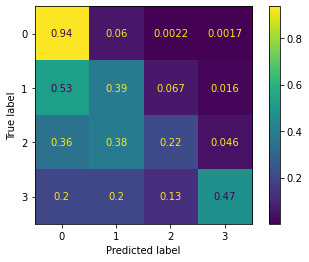

In [107]:
plot_confusion_matrix(xgb_pipe, X_train_smaller_clean, y_train, normalize='true')

__XGBoost - Iteration #2__

In this second iteration, we kept the same reduced features, but this time increase the `max_depth` and the `n_estimators` to the default hyperparameters.

In [108]:
xgb_pipe2 = imbpipe(steps=[
    ('ss', StandardScaler()),
    ('sm', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(random_state=42,
                          max_depth = 6,
                          tree_method='hist',
                          n_estimators = 100,
                          n_jobs = -1))
])

In [109]:
xgb_pipe2.fit(X_train_smaller_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('sm', SMOTE(random_state=42)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1,
                               objective='multi:softprob', random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1, tree_method='hist',
                               validate_parameters=1, verbosity=Non

In [110]:
print_cv_scores(xgb_pipe2, X_train_smaller_clean, y_train)

[0.89258297 0.8916919  0.89255506 0.89021475 0.89068343]
Training Accuracy 0.8915456248035225
##############
[0.88904482 0.88781686 0.88904482 0.88696366 0.88738538]
Cross_Val Accuracy 0.8880511077742398
##############
Training Macro Precision: 0.49506567270851465
Cross_Val Macro Precision: 0.4164346520997356
##############
Training Macro Recall: 0.49926469911187327
Cross_Val Macro Recall: 0.38364490384330346
##############
Training Macro F1: 0.48103326627206766
Cross_Val Macro F1: 0.3933767229547099


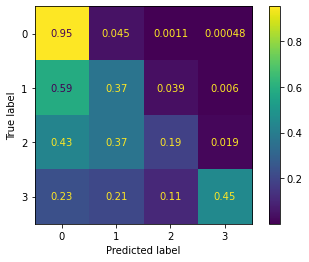

In [111]:
plot_confusion_matrix(xgb_pipe2, X_train_smaller_clean, y_train, normalize='true')

The XGBoost models are not performing well enough to continue iterating the modeling and tuning the hyperparameters.

### Logistic Regression

__Logistic Regression - Iteration #1__

Run logistic regression with standardized data and `class_weight` set to balanced to account for the class imbalance. Let's first look at all the features that could predict the severity of injuries.



In [47]:
lr_pipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced'))
])

In [49]:
lr_pipe.fit(X_train_clean, y_train)

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ss', StandardScaler()),
                ('lr', LogisticRegression(class_weight='balanced'))])

In [50]:
print_cv_scores(lr_pipe, X_train_clean, y_train)

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

[0.75627289 0.75692674 0.7562988  0.75786565 0.75716046]
Training Accuracy 0.7569049076094129
##############
[0.75532449 0.75813924 0.75379353 0.75503744 0.75685352]
Cross_Val Accuracy 0.7558296430991228
##############
Training Macro Precision: 0.32364007246581705
Cross_Val Macro Precision: 0.3198453674715446
##############
Training Macro Recall: 0.6321334757855323
Cross_Val Macro Recall: 0.5608080272231616
##############
Training Macro F1: 0.338734935690843
Cross_Val Macro F1: 0.3321304489876994


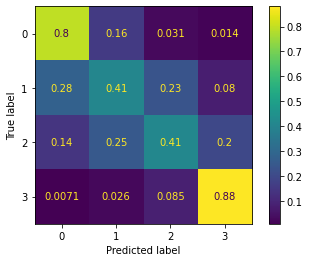

In [51]:
plot_confusion_matrix(lr_pipe, X_train_clean, y_train, normalize='true');

Evaluation of this model shows higher macro recall scores showing that logistic regression may prove to be better at avoiding the misclassification of severe injuries and fatalities.

__Logistic Regression - Iteration #2__

Run logistic regression again, this time using SMOTE and reduced features.

In [121]:
lr_pipe2 = imbpipe(steps=[
    ('ss', StandardScaler()),
    ('sm', SMOTE(random_state=42)),
    ('lr', LogisticRegression(class_weight='balanced'))
])

In [122]:
lr_pipe2.fit(X_train_smaller_clean, y_train)

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ss', StandardScaler()), ('sm', SMOTE(random_state=42)),
                ('lr', LogisticRegression(class_weight='balanced'))])

In [123]:
print_cv_scores(lr_pipe2, X_train_smaller_clean, y_train)

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

[0.73391635 0.73753446 0.73536758 0.73711584 0.73656617]
Training Accuracy 0.7361000805089792
##############
[0.73375541 0.7393849  0.73235203 0.73562925 0.73733355]
Cross_Val Accuracy 0.7356910276348103
##############
Training Macro Precision: 0.3118047514295263
Cross_Val Macro Precision: 0.31033296869168064
##############
Training Macro Recall: 0.5771797274646661
Cross_Val Macro Recall: 0.542745603663163
##############
Training Macro F1: 0.31809580904163215
Cross_Val Macro F1: 0.31557155203433584


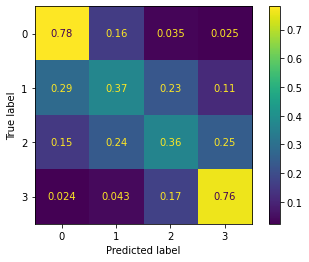

In [124]:
plot_confusion_matrix(lr_pipe2, X_train_smaller_clean, y_train, normalize='true');

Evaluation of this second iteration shows that by reducing the features, the model does not perform as well using the macro recall.

__Logistic Regression - Iteration #3__

Run logistic regression again, this time using SMOTE and all features.

In [126]:
lr_pipe3 = imbpipe(steps=[
    ('ss', StandardScaler()),
    ('sm', SMOTE(random_state=42)),
    ('lr', LogisticRegression(class_weight='balanced'))
])

In [127]:
lr_pipe3.fit(X_train_clean, y_train)

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ss', StandardScaler()), ('sm', SMOTE(random_state=42)),
                ('lr', LogisticRegression(class_weight='balanced'))])

In [128]:
print_cv_scores(lr_pipe3, X_train_clean, y_train)

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

[0.7394402  0.74006016 0.73972526 0.74161904 0.74026003]
Training Accuracy 0.7402209378940701
##############
[0.73879484 0.74235115 0.73581265 0.73939288 0.73940675]
Cross_Val Accuracy 0.7391516524176441
##############
Training Macro Precision: 0.31864032801898784
Cross_Val Macro Precision: 0.31483896155941554
##############
Training Macro Recall: 0.6206139865781942
Cross_Val Macro Recall: 0.5490065526301652
##############
Training Macro F1: 0.3300999353589682
Cross_Val Macro F1: 0.32350129893717916


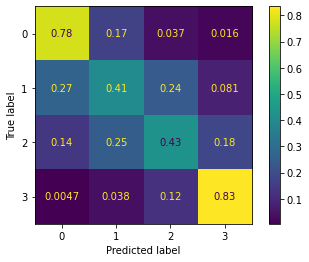

In [129]:
plot_confusion_matrix(lr_pipe3, X_train_clean, y_train, normalize='true');

In this third iteration, we see that using SMOTE with all of the original features leads to similar performance as the first iteration of logistic regression, but this time using SMOTE in addition to `class_weight`. 

__Logistic Regression - Iteration #4__

Run logistic regression with a balanced class_weight and `GridSearchCV` to investigate the reguarization strength.

In [136]:
lr_pipe4 = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(random_state=42,
                              class_weight='balanced'))
])

In [137]:
grid_params = [{'lr__C': [0.01, 0.1, 1, 10]}]

In [139]:
gs_pipe = GridSearchCV(estimator=lr_pipe4, param_grid=grid_params)

In [140]:
gs_pipe.fit(X_train_clean, y_train)

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             param_grid=[{'lr__C': [0.01, 0.1, 1, 10]}])

In [142]:
gs_pipe.best_params_

{'lr__C': 0.01}

In [144]:
pd.DataFrame(gs_pipe.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,34.910760,1.042334,0.270563,0.018683,0.01,{'lr__C': 0.01},0.754942,0.758251,0.753945,0.755763,0.757141,0.756008,0.001534,1
1,34.917335,0.602194,0.261455,0.003561,0.1,{'lr__C': 0.1},0.755484,0.757924,0.754647,0.754487,0.756758,0.755860,0.001309,2
2,35.042417,0.793601,0.262634,0.002566,1,{'lr__C': 1},0.755324,0.758139,0.753794,0.755037,0.756854,0.755830,0.001511,3
3,35.624056,0.753170,0.263978,0.005521,10,{'lr__C': 10},0.754599,0.757669,0.754487,0.755388,0.756367,0.755702,0.001192,4


In [147]:
lr_pipe5 = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced',
                              random_state=42,
                              C=0.01,
                              max_iter = 1000))
])

In [148]:
lr_pipe5.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('lr',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=1000, random_state=42))])

In [149]:
print_cv_scores(lr_pipe5, X_train_clean, y_train)

[0.75625295 0.75696661 0.75705033 0.75798127 0.75704683]
Training Accuracy 0.7570595993378438
##############
[0.75489391 0.75825884 0.75420816 0.75508528 0.75697313]
Cross_Val Accuracy 0.755883865008856
##############
Training Macro Precision: 0.32372039813422654
Cross_Val Macro Precision: 0.31977378223091835
##############
Training Macro Recall: 0.631943052556208
Cross_Val Macro Recall: 0.5594162367288915
##############
Training Macro F1: 0.33892263949417256
Cross_Val Macro F1: 0.33205626863525345


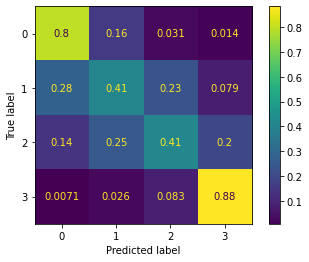

In [150]:
plot_confusion_matrix(lr_pipe5, X_train_clean, y_train, normalize='true');

## Final Model Evaluation

Prepare `X_test` for final evaluation.

In [151]:
X_test_clean = cleaning_pipeline.transform(X_test)

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-61-41f05342683b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [152]:
y_pred = lr_pipe5.predict(X_test_clean)

In [153]:
lr_pipe5.score(X_test_clean, y_test)

0.7580746247948751

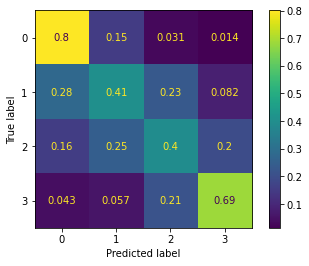

In [155]:
plot_confusion_matrix(lr_pipe5, X_test_clean, y_test, normalize='true');

In [156]:
recall_score(y_test, y_pred, average='macro')

0.572132664395615

In [157]:
precision_score(y_test, y_pred, average='macro')

0.32101410927975227

In [161]:
f1_score(y_test, y_pred, average='macro')

0.33408256437572525